[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ebgv/Planet--Understanding-the-Amazon-from-Space/blob/master/main_Eric_v1.ipynb)

# Planet: Understanding the Amazon from Space

## 0. Installing all the required packages

In [1]:
# to install pytorch on colab
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x56b44000 @  0x7fdb9c3be2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [2]:
!pip install -U bcolz

    100% |████████████████████████████████| 1.5MB 13.4MB/s 
  Running setup.py bdist_wheel for bcolz ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [3]:
!pip install Pillow==4.0.0

    100% |████████████████████████████████| 5.6MB 5.9MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [0]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import bcolz
import time
%matplotlib inline

## 1. Downloading the data

First, we create the directory where we will store the data:

In [5]:
!pwd
!mkdir data
!ls

/content
data  sample_data


Now we retrive the data from kaggle:

In [0]:
# First downloading the Kaggle API token
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"danielwientjens","key":"57cf17d52f3b8964bfc1796533f16115"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# downloading from kaggle:
## train_v2.csv
% cd /content
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p data
# unzipping
% cd /content/data
!unzip train_v2.csv.zip -d /content/data

## train-jpg.tar.7z
% cd /content
!kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p data
# unzipping 
% cd /content/data
!7z x -so train-jpg.tar.7z | tar xf - -C /content/data

/content
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 50.5MB/s]
/content/data
Archive:  train_v2.csv.zip
  inflating: /content/data/train_v2.csv  
   creating: /content/data/__MACOSX/
  inflating: /content/data/__MACOSX/._train_v2.csv  
/content
 99% 593M/600M [00:04<00:00, 170MB/s]
100% 600M/600M [00:04<00:00, 127MB/s]
/content/data


In [8]:
# Check files:
%cd /content/data
%ls

/content/data
__MACOSX/  train-jpg/  train-jpg.tar.7z  train_v2.csv  train_v2.csv.zip


## 2.  Loading the data

Let's visualize the data, we have a .csv file with the image labels:

In [9]:
train_label = pd.read_csv('/content/data/train_v2.csv')
train_label.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
len(train_label)

40479

Add the weather_tags:

In [11]:
weather_list = ['partly_cloudy', 'haze', 'cloudy', 'clear']
weather_tag_list = [[element for element in tag.split() if element in weather_list] for tag in train_label['tags']]
train_label['weather_tags'] = [''.join(tag) for tag in weather_tag_list]
train_label.head()

,image_name,tags,weather_tags
0,train_0,haze primary,haze
1,train_1,agriculture clear primary water,clear
2,train_2,clear primary,clear
3,train_3,clear primary,clear
4,train_4,agriculture clear habitation primary road,clear


And the image folder:

/content/data/train-jpg


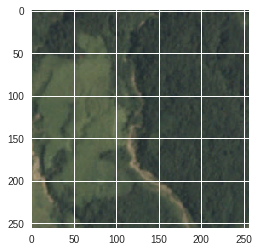

In [12]:
% cd /content/data/train-jpg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img = mpimg.imread('train_1.jpg')
imgplot = plt.imshow(img)
plt.show()

Now we can proceed to the data loading:

In [0]:
img_path = '/content/data/train-jpg/'
img_ext = '.jpg'
train_data = '/content/data/train_v2.csv'

In [0]:
from torch.utils.data.dataset import Dataset
from sklearn.preprocessing import MultiLabelBinarizer

class KaggleAmazonDataset(Dataset):
  def __init__(self, csv_path, img_path, img_ext, transform=None):
    # Check that all images mentioned in the .csv exist in the folder:
    tmp_df = train_label #pd.read_csv('/content/data/train_v2.csv')
    assert tmp_df['image_name'].apply(lambda x: os.path.isfile(img_path+x+img_ext)).all(), "Some images referenced in the CSV file were not found"
      
    self.mlb = MultiLabelBinarizer()
    self.img_path = img_path
    self.img_ext = img_ext
    self.transform = transform
      
    self.X_train = tmp_df['image_name']
    self.Y_train = self.mlb.fit_transform(tmp_df['weather_tags'].str.split()).astype(np.float32)
      
  def __getitem__(self, index):
    img = Image.open(self.img_path + self.X_train[index] + self.img_ext)
    img = img.convert('RGB')
    
    if self.transform is not None:
      img = self.transform(img)
      
    label = torch.from_numpy(self.Y_train[index]) # Create a tensor from np array
    return img, label
  
  def __len__(self):
    return len(self.X_train.index)

We need to define now the transformation we want to apply to the iamge:

In [0]:
# Using torchvision image transformation options we resize them and convert them into a tensor:
transformations = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])


In [0]:
dset_train = KaggleAmazonDataset(train_data,img_path, img_ext, transformations)

As an example of the resulting data formatting, extracting the first image:

In [29]:
dset_train[1]

(tensor([[[0.2431, 0.2392, 0.2510,  ..., 0.2196, 0.2588, 0.2392],
          [0.2549, 0.2471, 0.2471,  ..., 0.2157, 0.2549, 0.2863],
          [0.2471, 0.2549, 0.2314,  ..., 0.2078, 0.2275, 0.2667],
          ...,
          [0.4039, 0.4000, 0.3608,  ..., 0.2078, 0.2157, 0.2196],
          [0.3961, 0.3961, 0.3569,  ..., 0.2000, 0.2235, 0.2157],
          [0.3843, 0.3765, 0.3725,  ..., 0.2000, 0.2431, 0.2627]],
 
         [[0.2784, 0.2863, 0.3020,  ..., 0.2627, 0.3059, 0.2863],
          [0.2941, 0.2941, 0.2902,  ..., 0.2549, 0.2980, 0.3333],
          [0.2902, 0.3059, 0.2784,  ..., 0.2471, 0.2706, 0.3137],
          ...,
          [0.4314, 0.4275, 0.3961,  ..., 0.2588, 0.2667, 0.2706],
          [0.4275, 0.4157, 0.3961,  ..., 0.2431, 0.2706, 0.2627],
          [0.4118, 0.4039, 0.4000,  ..., 0.2471, 0.2902, 0.3020]],
 
         [[0.2471, 0.2471, 0.2549,  ..., 0.2353, 0.2549, 0.2431],
          [0.2549, 0.2510, 0.2510,  ..., 0.2353, 0.2510, 0.2667],
          [0.2510, 0.2549, 0.2431,  ...,

With the data storage created we can load data with DataLoader:

In [0]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dset_train,
                          batch_size=256,
                          shuffle=True, # Reshuffle data at every epoch
                          num_workers=1,
                          pin_memory=True # CUDA only
                         )

## 3. Model development

Check if a GPU is available:

In [31]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

Using gpu: True 


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(2304, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1) # Flatten layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

#model = Net() # On CPU
model = Net().cuda() # On GPU

Defining the optimizer:

In [0]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

Defining the training function:

In [0]:
import torch.nn.functional as F

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

And train the model:

In [48]:
for epoch in range(1, 2):
    train(epoch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


Train Epoch: 1 [0/40479 (0%)]	Loss: 0.698736
Train Epoch: 1 [2560/40479 (6%)]	Loss: 0.684137
Train Epoch: 1 [5120/40479 (13%)]	Loss: 0.667166
Train Epoch: 1 [7680/40479 (19%)]	Loss: 0.644141
Train Epoch: 1 [10240/40479 (25%)]	Loss: 0.615572
Train Epoch: 1 [12800/40479 (31%)]	Loss: 0.579931
Train Epoch: 1 [15360/40479 (38%)]	Loss: 0.527291
Train Epoch: 1 [17920/40479 (44%)]	Loss: 0.495886
Train Epoch: 1 [20480/40479 (50%)]	Loss: 0.456831
Train Epoch: 1 [23040/40479 (57%)]	Loss: 0.418036
Train Epoch: 1 [25600/40479 (63%)]	Loss: 0.456203
Train Epoch: 1 [28160/40479 (69%)]	Loss: 0.469202
Train Epoch: 1 [30720/40479 (75%)]	Loss: 0.428555
Train Epoch: 1 [33280/40479 (82%)]	Loss: 0.448076
Train Epoch: 1 [35840/40479 (88%)]	Loss: 0.472512
Train Epoch: 1 [38400/40479 (94%)]	Loss: 0.443304
